#### 4-1 割引クーポンキャンペーンの効果最大化

1. 各会員にどのパターンのダイレクトメールを送付するか
2. 各会員に対し送付するパターンは1つ
3. クーポン付与により来客増加数を最大化
4. 予算100万円以下
5. それぞれのセグメント会員の10%に送付

In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time

In [2]:
files = glob('../*/*coupon/*.csv')
cust_df = pd.read_csv(files[0])
prob_df = pd.read_csv(files[1])

In [3]:
cust_df.info()
cust_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  5000 non-null   int64 
 1   age_cat      5000 non-null   object
 2   freq_cat     5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


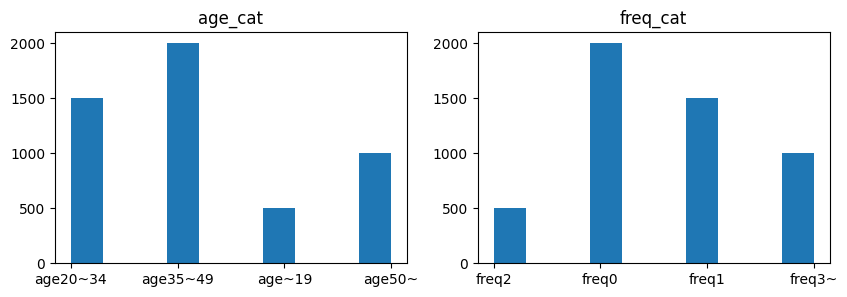

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].hist(cust_df['age_cat'])
axs[0].set_title('age_cat')
axs[1].hist(cust_df['freq_cat'])
axs[1].set_title('freq_cat')
plt.show()

<Axes: xlabel='freq_cat', ylabel='age_cat'>

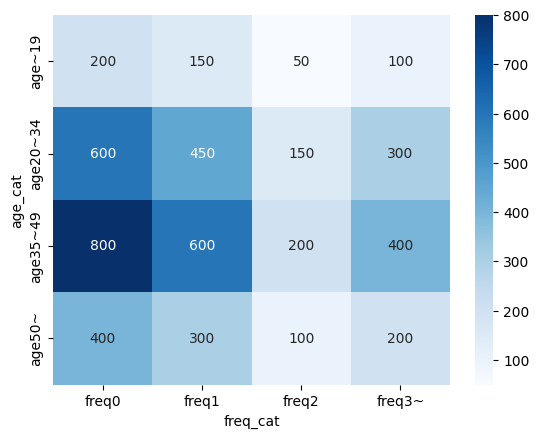

In [70]:
pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
pivot_df
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues')

In [71]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


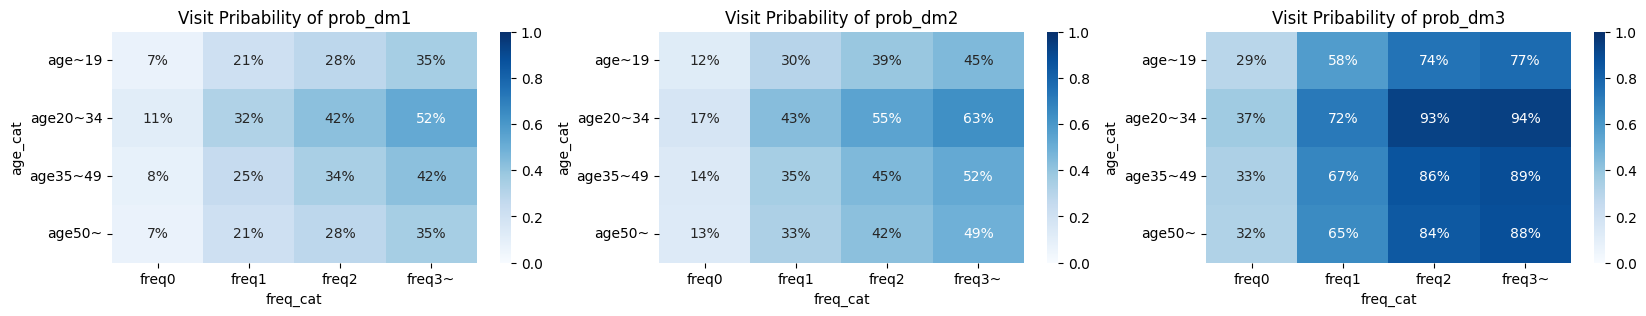

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'Visit Pribability of {ptn}')
plt.show()

数理モデル定義

In [8]:
problem = LpProblem(name='DiscountCouponProblem01', sense=LpMaximize)

変数定義

In [9]:
I = cust_df['customer_id'].to_list()
M = [i+1 for i in range(3)]

xim = {}
for i in I:
    for m in M:
        xim[i, m] = LpVariable(name=f'xim({i},{m})', cat='Binary')
len(xim)

15000

条件定義: 割りあては必ず一つ
$$ \sum_{m\in M} x_{im} = 1 $$

In [10]:
for i in I:
    problem += lpSum(xim[i, m] for m in M) == 1

条件定義 : 来客増加数最大化
$$
Maxmize : \sum_{m\in M} (P_{im} - P_{i1}) x_{im}
$$

In [11]:
# display(prob_df)
# display(cust_df.head())

keys = cust_df.columns[1:].to_list()
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

cust_prob_var_df = cust_prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2, 'prob_dm3':3})
cust_prob_var_df = cust_prob_var_df.melt(id_vars=['customer_id'], value_vars=[1, 2, 3], var_name='dm', value_name='prob')
cust_prob_var_df.head()

pim = cust_prob_var_df.set_index(['customer_id', 'dm'])['prob'].to_dict()
print(pim[1, 1])

problem += lpSum((pim[i, m] - pim[i, 1]) * xim[i, m] for i in I for m in [2, 3])

0.42


条件定義 : 100万円以下
$$
C_m \in [0, 1000, 2000] , \quad
\sum_{i\in I}\sum_{m\in M} C_m P_m x_{im} \le 1000000
$$

In [12]:
cm = {1: 0, 2: 1000, 3: 2000}
problem += lpSum(cm[m] * pim[i, m] * xim[i, m] for i in I for m in M) <= 1000000

条件定義 : 会員の10%に送付
$$ $$

In [20]:
S = prob_df['segment_id'].to_list()
len(S)
ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(ns)
si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
si

for s in S:
    for m in M:
        problem += lpSum(xim[i, m] for i in I if si[i] == s) >= 0.1 * ns[s]

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [14]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'Status : {LpStatus[status]}')
print(f'Result : {value(problem.objective):.04}')
print(f'Time : {time_stop - time_start:.03} (sec)')


Status : Optimal
Result : 326.1
Time : 6.82 (sec)


In [27]:
send_dm_df = pd.DataFrame(
    [[xim[i, m].value() for m in M] for i in I],
    columns=['send_dm1', 'send_dm2', 'send_dm3']
    )
display(send_dm_df.head())

cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
display(cust_send_df.head())

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,0.0,1.0
4,5,age35~49,freq0,0.0,1.0,0.0


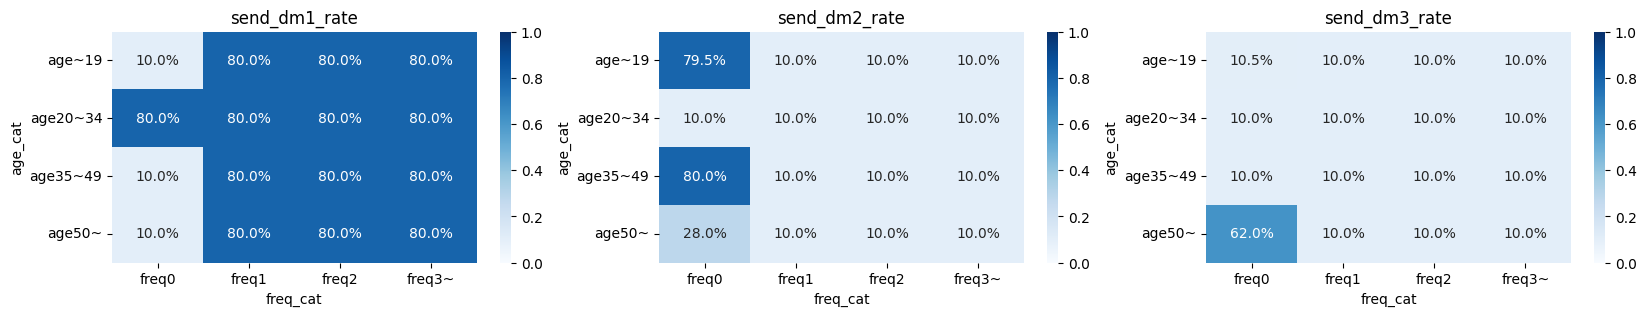

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_rate')
plt.show()

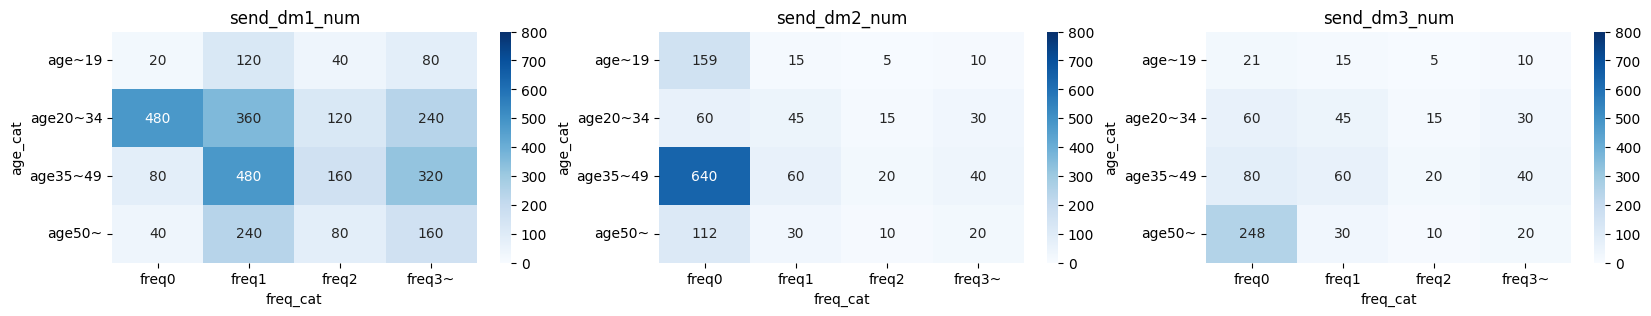

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, vmin=0, vmax=800, annot=True, fmt='.0f', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_num')
plt.show()

In [97]:
problem = LpProblem(name='DiscountCouponProblem02', sense=LpMaximize)

xsm = {}
for s in S:
    for m in M:
        xsm[s, m] = LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
len(xsm)

for s in S:
    problem += lpSum(xsm[s, m] for m in M) == 1
problem

prob_var_df = prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})
display(prob_var_df)
prob_var_df = prob_var_df.melt(id_vars=['segment_id'], value_vars=[1, 2, 3], var_name='dm', value_name='prob')
display(prob_var_df)
Psm = prob_var_df.set_index(['segment_id', 'dm'])['prob'].to_dict()
Psm

problem += lpSum(ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])
problem

problem += lpSum(cm[m] * ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000
problem

for s in S:
    for m in M:
        problem += xsm[s, m] >= 0.1
problem

time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'Status : {LpStatus[status]}')
print(f'Result : {value(problem.objective):.04}')
print(f'Time : {time_stop - time_start:.03} (sec)')

send_dm_df = pd.DataFrame(
    [[xsm[s, m].value() for m in M] for s in S],
    columns=['send_dm1', 'send_dm2', 'send_dm3']
    )
display(send_dm_df.head())

seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
display(seg_send_df.head())

,age_cat,freq_cat,segment_id,1,2,3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


,segment_id,dm,prob
0,1,1,0.07
1,2,1,0.21
2,3,1,0.28
3,4,1,0.35
4,5,1,0.11
5,6,1,0.32
6,7,1,0.42
7,8,1,0.52
8,9,1,0.08
9,10,1,0.25


Status : Optimal
Result : 326.1
Time : 0.113 (sec)


,send_dm1,send_dm2,send_dm3
0,0.1,0.8,0.1
1,0.8,0.1,0.1
2,0.8,0.1,0.1
3,0.8,0.1,0.1
4,0.8,0.1,0.1


,segment_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age~19,freq0,0.1,0.8,0.1
1,2,age~19,freq1,0.8,0.1,0.1
2,3,age~19,freq2,0.8,0.1,0.1
3,4,age~19,freq3~,0.8,0.1,0.1
4,5,age20~34,freq0,0.8,0.1,0.1
